In [1]:
from framework import StandardScaler
from dql import DQLAgent, DQLTrainer
from ddpg import DDPGAgent, DDPGTrainer, LichtenbergAgent

from PIL import Image
import gymnasium
import numpy as np

def to_gif(matrices, filepath, duration=25):
    frames = []
    for matrix in matrices:
        image = Image.fromarray(matrix)
        frames.append(image)
    frames[0].save(filepath, save_all=True, append_images=frames[1:], duration=duration, loop=0)

## Submarine

In [ ]:
from environments.submarine import ContinuousSubmarine
import time

episodes = []
time_taken = []
env = ContinuousSubmarine(delta_t=1, randomize=False) 
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
featurizer = StandardScaler(state_dim, learn=False)
featurizer.mean = np.array([ 7.73739964, 11.54841878,  1.6379028 ,  1.92430292])
featurizer.var = np.array([ 580.12531577, 1460.05771442,   36.57866531,   37.08183991])
# for training comparison stability, ensure that the featurizer scaling is constant

In [ ]:
for _ in range(1):
    # agent = DDPGAgent(state_dim, action_dim, batch_size=32, tau=0.05)
    agent = LichtenbergAgent(state_dim, action_dim, "figure2d.npy", batch_size=32, tau=0.1, n_iter=3, pop=15)

    trainer = DDPGTrainer(env, agent, featurizer, until_convergence=True, convergence_reward=100)
    start = time.perf_counter()
    trainer.train(episodes=10000)
    while not trainer.has_converged(100):
        trainer.train(episodes=100)
    episodes.append(len(trainer.episode_rewards))
    time_taken.append(int(round(time.perf_counter() - start)))
    # print(episodes[-1], time_taken[-1])
    # print(trainer.episode_rewards, trainer.actor_losses, trainer.critic_losses)
    # trainer.plot_losses()
    # trainer.plot_rewards()

## Parking

In [ ]:
import torch
class ParkingFeaturizer(StandardScaler):
    def __init__(self):
        super().__init__(19)
    
    def transform_state(self, state, info=None):
        speed = info['speed'] if info else 0.0
        state = np.concat([state['observation'], state['achieved_goal'], state['desired_goal'], np.array([speed])])
        return torch.tensor(state, dtype=torch.float32).unsqueeze(0)


In [ ]:
import highway_env.envs.parking_env as parking_env

env = parking_env.ParkingEnv({
    "observation": {
        "type": "KinematicsGoal",
        "features": ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
        "scales": [100, 100, 5, 5, 1, 1],
        "normalize": True
    },
    "action": {
        "type": "ContinuousAction"
    },
    "simulation_frequency": 15,
    "policy_frequency": 3,
    "screen_width": 600,
    "screen_height": 300,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": True
})
env.render_mode = 'rgb_array'
featurizer = ParkingFeaturizer()
agent = LichtenbergAgent(19, 2, "figure2d.npy", hidden_layers=3, tau=0.05, batch_size=64, n_iter=3, pop=15)
trainer = DDPGTrainer(env, agent, featurizer)

In [ ]:
trainer.train(episodes=10000)
# trainer.save()

## Inverted Pendulum

In [2]:
import torch

class PendulumFeaturizer(StandardScaler):
    def __init__(self):
        super().__init__(8, learn=False)
    
    def transform_state(self, state, info=None):
        state = state[:-1]
        normalized_state = (state - self.mean) / np.sqrt(self.var + 1e-8)
        return torch.tensor(normalized_state, dtype=torch.float32).unsqueeze(0)

#### Delayed pendulum has $n$ ms sampling time with $d \cdot n$ ms delay
In practice, this response delay may be the amount of time it takes to preprocess a data stream or to signal an action

In [3]:
camera_config = {
    "distance": 3.5
}
env = gymnasium.make('InvertedDoublePendulum-v5', render_mode='rgb_array', default_camera_config=camera_config, frame_skip=1)
# env.unwrapped.model.opt.timestep = 1e-3
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

featurizer = PendulumFeaturizer()
# experimentally approximated mean and standard deviation of state vector
featurizer.mean = np.array([-0.0537724 , # position of the cart along the linear surface (m)
                             0.00854607, # sine of the angle between the cart and the first pole
                            -0.0020691 , # sine of the angle between the two poles
                             0.97681748, # cosine of the angle between the cart and the first pole
                             0.97418304, # cosine of the angle between the two poles
                             0.00404627, # velocity of the cart (m/s)
                             0.03138314, # angular velocity of the angle between the cart and the first pole (rad/s)
                            -0.03641539, # angular velocity of the angle between the two poles (rad/s)
                            -0.0363062 , # constraint force - 1 (N)
                             0.        , # constraint force - 2 (N)
                             0.          # constraint force - 3 (N)
                             ])[:-3]
featurizer.var = np.array([4.08496608e-02, 9.94629836e-02, 1.39189335e-01, 7.58616097e-03,
                           1.25376890e-02, 6.61337497e+00, 2.03311682e+01, 1.82406234e+01,
                           3.15706362e-02, 0.00000000e+00, 0.00000000e+00])[:-3]

In [33]:
# use same agent throughout for better starting weights
agent = DDPGAgent(state_dim-1, action_dim, hidden_dim=64, hidden_layers=2, tau=0.1, batch_size=64)

In [ ]:
# avg_rewards = []
# std_rewards = []
# convergence_episode = []
# delays = [*range(0, 5), *range(5, 51, 5), *range(50, 101, 10)] # delay in ms
# n = 100 # episodes per test


for delay in delays:
    print(f"Delay: {delay}")
    trainer = DDPGTrainer(env, agent, featurizer, until_convergence=True, convergence_reward=8000, delay=delay)
    trainer.train(episodes=5000)
    rewards = np.array([trainer.run_episode(False)['reward'] for _ in range(n)])
    avg_rewards.append(np.mean(rewards))
    std_rewards.append(np.std(rewards)/np.sqrt(n))
    convergence_episode.append(len(trainer.episode_rewards))
    # save it
    np.save(f"avg_rewards.npy", avg_rewards)
    np.save(f"std_rewards.npy", std_rewards)
    np.save(f"convergence_episode.npy", convergence_episode)

Delay: 0


  8%|▊         | 407/5000 [00:22<04:48, 15.94it/s]

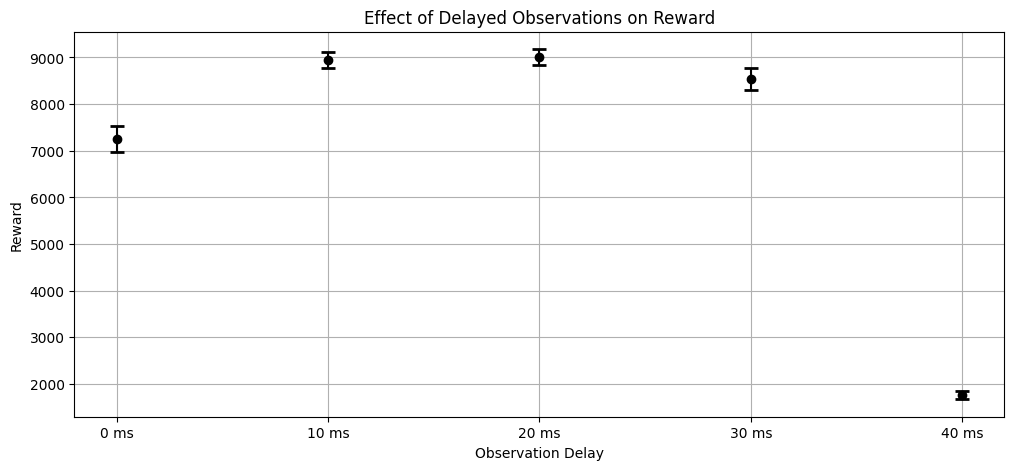

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))
trials = 1
X = np.array(delays[:len(avg_rewards[::trials])])*10
y = [np.mean(avg_rewards[i:i+trials]) for i in range(0, len(avg_rewards), trials)]
yerr = [np.mean(std_rewards[i:i+trials]) for i in range(0, len(std_rewards), trials)]

ax.errorbar(X, y, yerr=yerr, fmt="o", capsize=5, capthick=2, color="black")
ax.set_xlabel("Observation Delay")
ax.set_ylabel("Reward")
ax.set_title("Effect of Delayed Observations on Reward")
ax.set_xticks(X)
ax.set_xticklabels(["{:.0f} ms".format(x) for x in X])
ax.grid()
plt.show()


## Ball and Beam Problem

In [ ]:
import ballbeam_gym.envs
import warnings
warnings.filterwarnings('ignore')

env = ballbeam_gym.envs.BallBeamSetpointEnv(timestep=0.02, setpoint=-0.8, beam_length=2.0, max_angle=0.5, max_timesteps=500, action_mode='discrete')
env.action_space = np.arange(3)
state_dim = env.observation_space.shape[0]

featurizer = StandardScaler(state_dim)
agent = DQLAgent(state_dim, env.action_space.shape[0], batch_size=128, epsilon_decay=0.9995)

In [ ]:
trainer = DQLTrainer(env, agent, featurizer)
trainer.train(episodes=1000)
trainer.plot_losses()

In [ ]:
info = trainer.run_episode()
to_gif(info['rgb_arrays'], 'ball_and_beam.gif', duration=25)

## Panda Reach

In [ ]:
import torch
class PandaFeaturizer(StandardScaler):
    def __init__(self):
        super().__init__(12)
    
    def transform_state(self, state, info=None):
        state = np.concatenate([state['achieved_goal'], state['desired_goal'], state['observation']])
        return torch.tensor(state, dtype=torch.float32).unsqueeze(0)

In [ ]:
import gymnasium 
import panda_gym
env = gymnasium.make('PandaReach-v3', render_mode="rgb_array")
featurizer = PandaFeaturizer()
agent = DDPGAgent(12, env.action_space.shape[0])
trainer = DDPGTrainer(env, agent, featurizer)
